In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import jdcal
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime as dt
from scipy.stats import pearsonr
import time
import pandas as pd
from scipy.stats import pearsonr

### Function to convert datetime object to fractional year

In [3]:
#convert dates to fractional years
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

### Function for MgII Regression Model

In [4]:
def func(X, m0, m1, m2):
    x, y = X
    return m0 + m1*x + m2*y

In [30]:
obs = pd.read_csv('MgII_composite.dat', header = 23, delim_whitespace=True, names = ['Fractional Year', 'Month', 'Day', 'index', 'uncertainty(1s)', 'source id'])
#zeros = pd.read_csv('adapt_magbins_with_lastobs.txt', header= None, sep=' ', names = ['Year', 'Month', 'Day', 'UT', 'JD', 'Earth Orbit Radius', 'Last_Obs_DA', 'magbin_01', 'magbin_02', 'magbin_03', 'magbin_04', 'magbin_05', 'magbin_06', 'magbin_07', 'magbin_08', 'magbin_09', 'magbin_10', 'magbin_11', 'magbin_12', 'magbin_13', 'magbin_14', 'magbin_15', 'magbin_16'])
zeros = pd.read_csv('ADAPT_mag_sums.txt', header=20, delim_whitespace=True, names = ['Year', 'Month', 'Day', 'UT', 'JD', 'Earth Orbit Radius', 'Last_Obs_DA', 'M_P', 'M_A'])

#filter for data at 12UT
zeros = zeros[zeros['UT'] == 1200]

#convert dates to fractional year
yz = zeros['Year'].tolist()
mz = zeros['Month'].tolist()
dz = zeros['Day'].tolist()
yo = np.floor(obs['Fractional Year']).tolist()
mo = obs['Month'].tolist()
do = obs['Day'].tolist()
fy_mg = []
new_fy_obs = []
for i in range(len(yz)):
    fy_mg.append(toYearFraction(dt(int(yz[i]), int(mz[i]), int(dz[i]))))
for i in range(len(yo)):
    new_fy_obs.append(toYearFraction(dt(int(yo[i]), int(mo[i]), int(do[i]))))
zeros['Fractional Year'] = fy_mg
obs['New Fractional Year'] = new_fy_obs

#only look at 2002-2011 data
obs_0211 = obs[obs['New Fractional Year'].between(2002,2011)]
zeros_0211 = zeros[zeros['Fractional Year'].between(2002,np.max(obs_0211['New Fractional Year']))]
obs_0211 = obs_0211[obs_0211['New Fractional Year'].isin(zeros_0211['Fractional Year'])]

### Magnetic Sums Linear Regression Model to MgII

In [31]:
#fit mag sums to MgII
param, param_cov = curve_fit(func, (np.array(zeros_0211['M_P']), np.array(zeros_0211['M_A'])), np.array(obs_0211['index']))
print('MgII Modeled Fit:')
print(str(round(param[0], 4)), '+', str(round(param[1], 6))+'*S_P', '+', str(round(param[2], 7))+'*S_A')

mod = param[0] + param[1]*np.array(zeros_0211['M_P']) + param[2]*np.array(zeros_0211['M_A'])

#calculate pearson coefficient
corr, _ = pearsonr(mod, obs_0211['index'])
print('Pearson coefficient:', str(round(corr, 3)))

MgII Modeled Fit:
0.1496 + 0.002392*S_P + 0.0004199*S_A
Pearson coefficient: 0.971


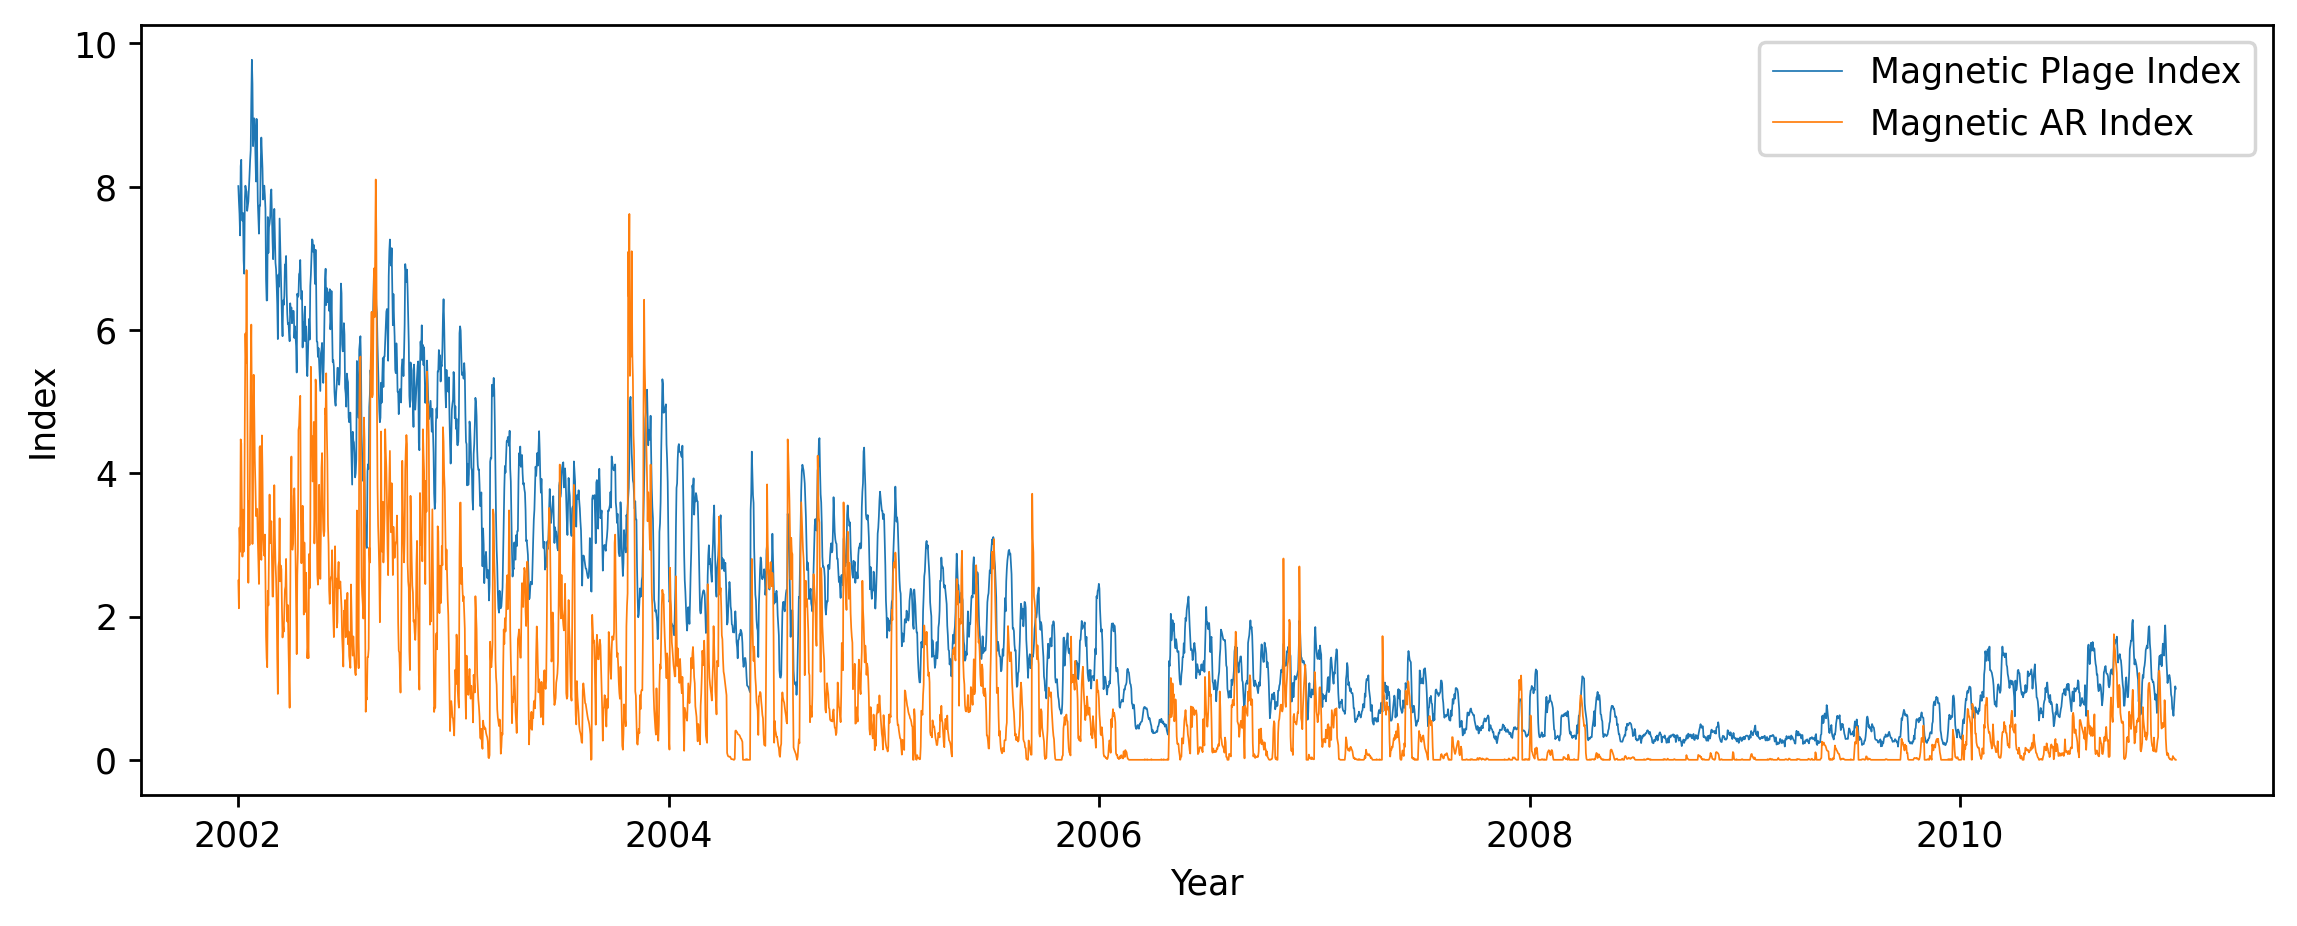

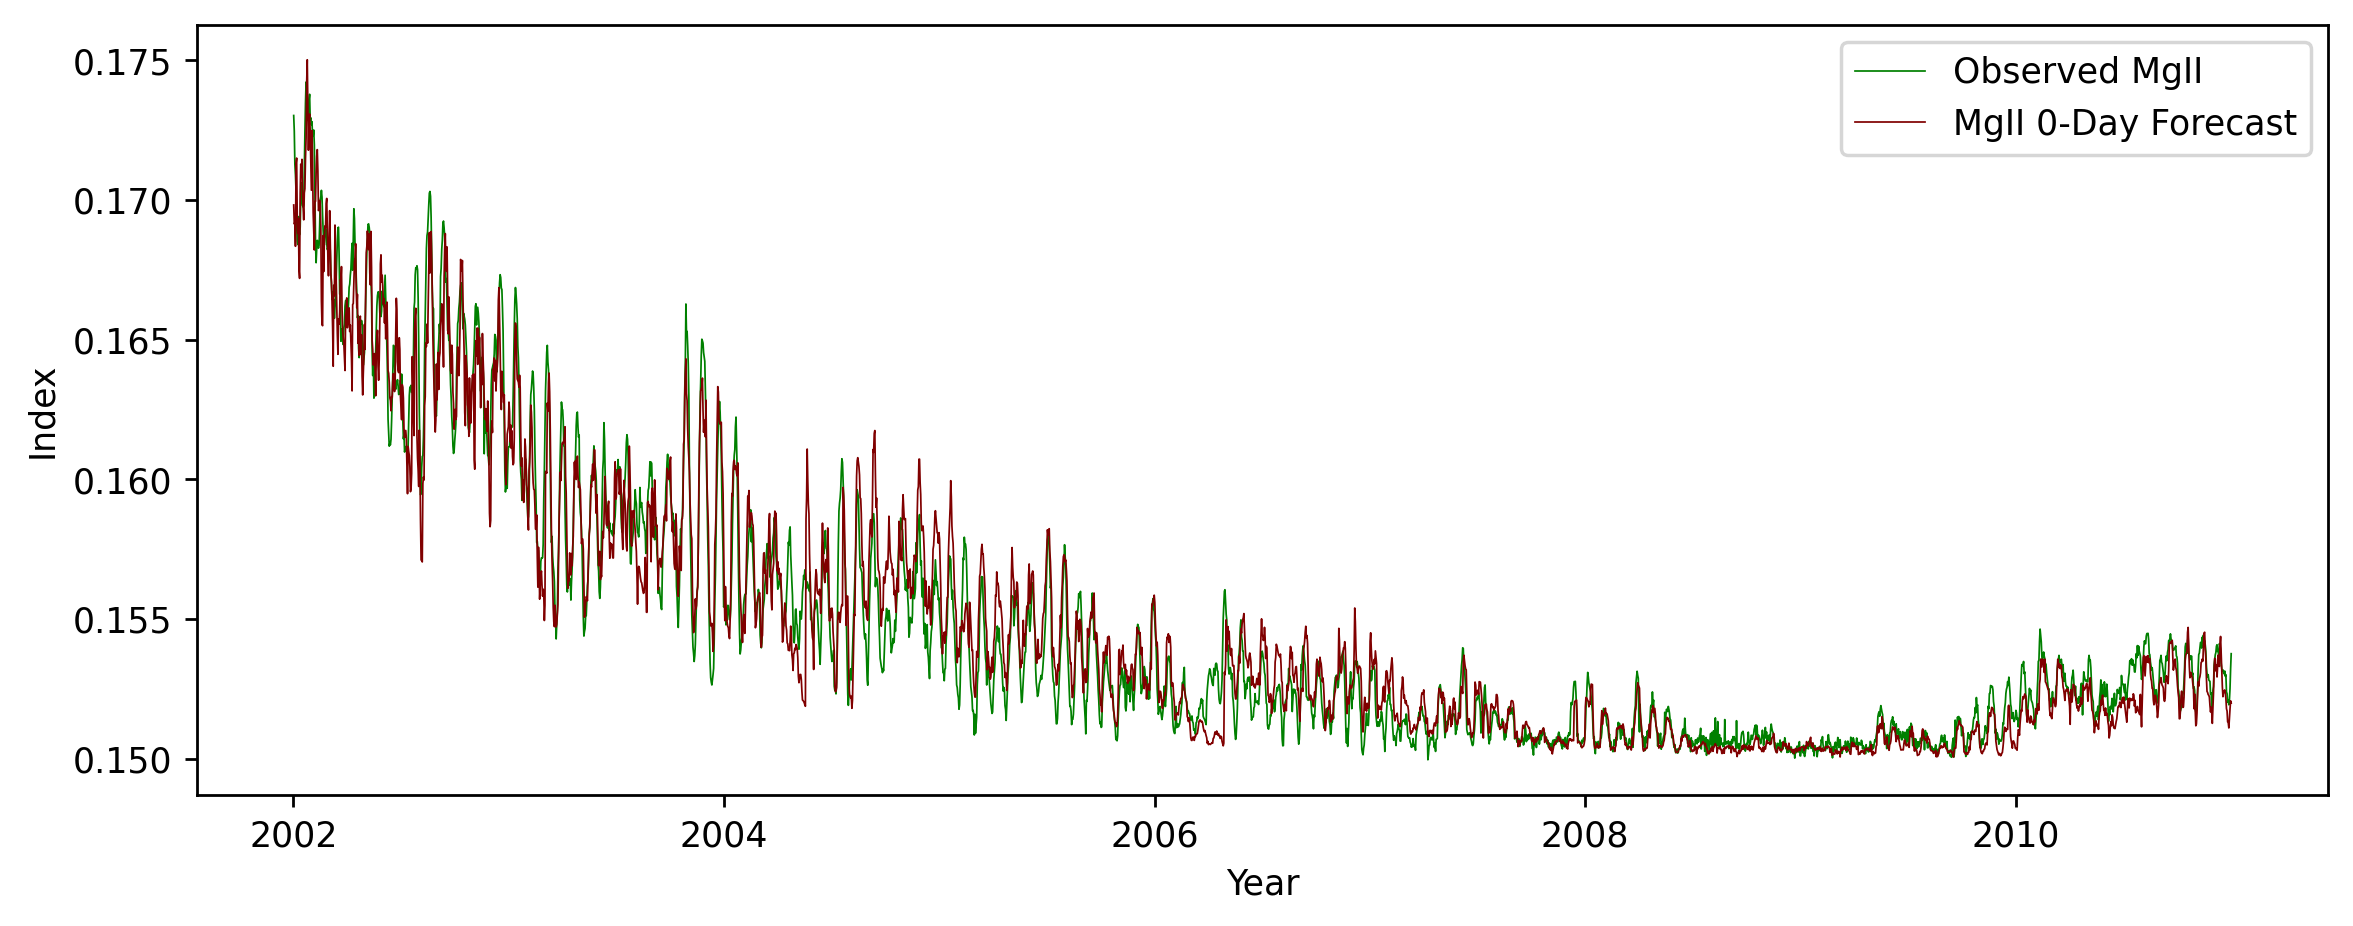

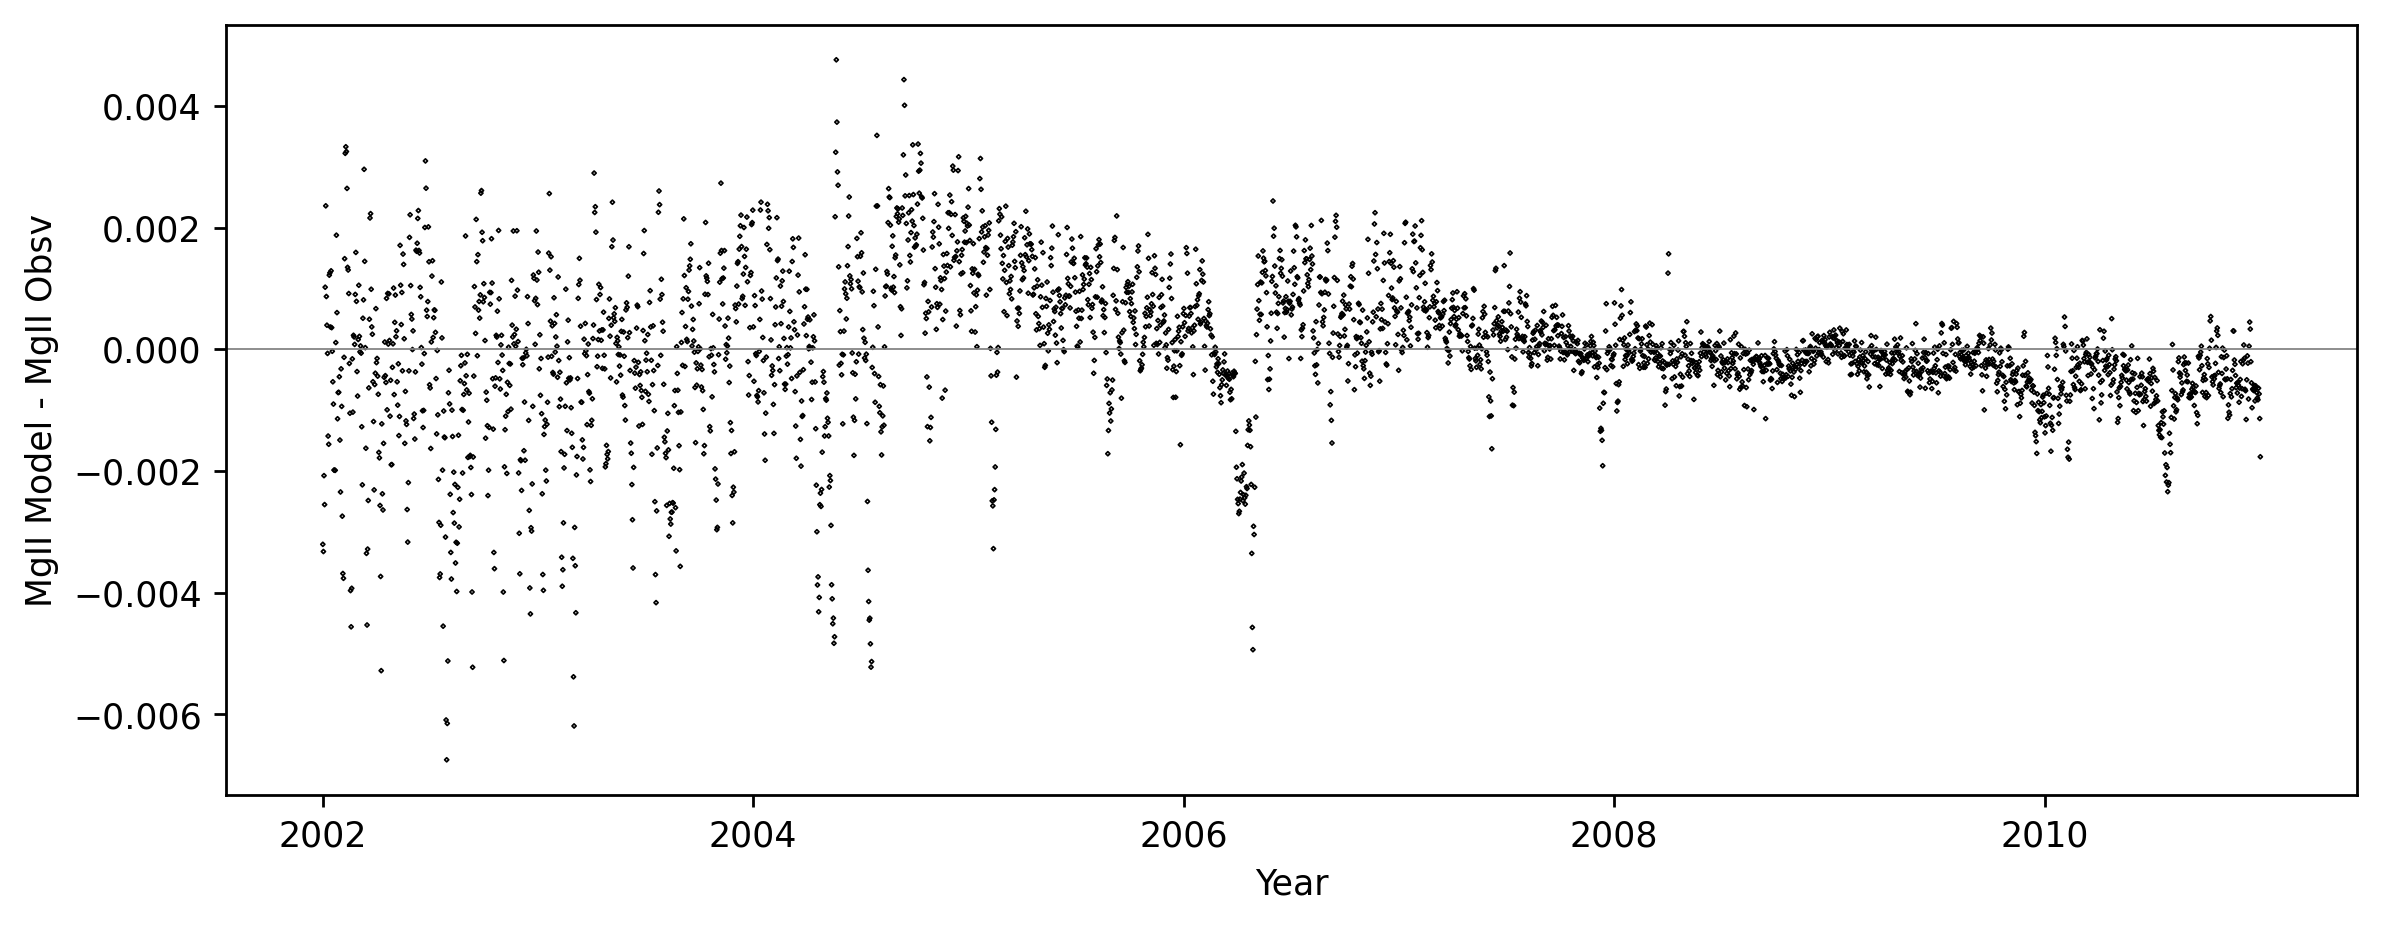

In [26]:
#Plage and AR sums plot
plt.figure(figsize=(11, 4), dpi=250)
plt.plot(obs_0211['Fractional Year'], zeros_0211['M_P'], linewidth=0.5, label='Magnetic Plage Index')
plt.plot(obs_0211['Fractional Year'], zeros_0211['M_A'], linewidth=0.5, label='Magnetic AR Index')
plt.xlabel('Year')
plt.ylabel('Index')
plt.legend()
plt.show()

#MgII model and observations comparison plot
plt.figure(plt.figure(figsize=(11, 4), dpi=250))
plt.plot(obs_0211['Fractional Year'], obs_0211['index'], color='g', linewidth=0.5, label='Observed MgII')
plt.plot(obs_0211['Fractional Year'], mod, linewidth=0.5, color='maroon',label='MgII 0-Day Forecast')
plt.xlabel('Year')
plt.ylabel('Index')
plt.legend()
plt.show()

#model difference
plt.figure(plt.figure(figsize=(11, 4), dpi=250))
plt.scatter(obs_0211['Fractional Year'], ((np.array(mod)-np.array(obs_0211['index']))), marker= 'D', facecolors='none',linewidth=0.5, color='k', s=0.7)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('MgII Model - MgII Obsv')
plt.show()